<a href="https://colab.research.google.com/github/castrokelly/Data-Science/blob/main/Po%C3%A7os_27_28_Ensemble_Analise_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abordagem Ensemble para Detecção e Classificação de Anomalias em Poços de Petróleo: um Estudo Aplicado ao Dataset 3W

**Centro de Ciências Matemáticas Aplicadas à Indústria (CeMEAI)**</br>
**Instituto de Ciências Matemáticas e de Computação (ICMC)**</br>
**Universidade de São Paulo**</br>
</br>
Aluna: **Kelly Christine Alvarenga de Castro**
Área de concentração: Ciências de Dados
Orientador: **Prof. Dr. Cláudio Fabiano Motta Toledo**
</br>
---

**Evento:** Formação de hidratos na linha de produção  
**Dados Utilizados:**
**Poço 27** (treinamento e teste): `/content/3W/dataset/8/WELL-00027_20230918170106.parquet`

**Poço 28** (validação): `/content/3W/dataset/8/WELL-00028_20210617053128.parquet`</br>

**Abordagem:**
* 1. Carregar os dados e remover colunas indesejadas.
* 2. Segmentar (`windowing`) os dados em janelas de **2100** linhas (35 minutos).
* 3. Agregar as features estatísticas de cada janela e definir o rótulo (usando o valor máximo de "class") e a flag `"is_anomaly"`.
* 4. Pré-processar os dados (remoção de colunas com `NA` nos sensores, eliminação de features com variância zero, normalização e PCA).
* 5. Dividir as janelas do Poço 27 em treino (70%) e teste (30%) e balancear o conjunto de treinamento.
* 6. Definir os modelos: Random Forest, Gradient Boosting e um modelo LSTM (adaptado para receber dados 2D e fazer reshape interno).
* 7. Integrar os modelos via `StackingClassifier` e avaliar o desempenho nos dados de Poço 27 e na validação do Poço 28.

**Observação:** Usamos uma classe personalizada `CustomKerasClassifier` para sobrescrever `_get_tags`, contornando um erro relacionado a `__sklearn_tags__`.

A abordagem proposta combina técnicas de:
- Segmentação temporal em janelas,
- Extração estatística de features,
- Redução de dimensionalidade com PCA,
- Modelagem com três algoritmos distintos: Random Forest (RF), Gradient Boosting (GB) e Long Short-Term Memory (LSTM),
- Combinação de modelos por meio de empilhamento (stacking manual).

O objetivo é verificar a capacidade de generalização do modelo em dados reais de produção, com foco na detecção precisa de anomalias relacionadas à formação de hidratos.


# 📚 Índice

- [1. Introdução](#1-introducao)
- [2. Carregamento e Pré-processamento dos Dados](#2-carregamento-e-pre-processamento-dos-dados)
- [3. Redução de Dimensionalidade com PCA](#3-reducao-de-dimensionalidade-com-pca)
- [4. Treinamento dos Modelos Individuais](#4-treinamento-dos-modelos-individuais)
- [5. Avaliação dos Modelos no Poço 27](#5-avaliacao-dos-modelos-no-poco-27)
- [6. Avaliação dos Modelos no Poço 28](#6-avaliacao-dos-modelos-no-poco-28)
- [7. Comparação entre os Modelos](#7-comparacao-entre-os-modelos)
- [8. Conclusão e Discussão dos Resultados](#8-conclusao-e-discussao-dos-resultados)

# 1. Introdução


Clonagem do repositório contendo o dataset 3W e instalação das bibliotecas necessárias:

In [3]:
!git clone https://github.com/petrobras/3W.git

Cloning into '3W'...
remote: Enumerating objects: 8700, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 8700 (delta 164), reused 146 (delta 146), pack-reused 8462 (from 2)
Receiving objects: 100% (8700/8700), 3.06 GiB | 27.25 MiB/s, done.
Resolving deltas: 100% (2843/2843), done.
Updating files: 100% (2324/2324), done.


Importação das bibliotecas necessárias para manipulação dos dados, pré-processamento, construção e avaliação dos modelos:

In [4]:
!pip install --upgrade scikeras scikit-learn


In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc

!pip install imblearn -q
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# Funções utilitárias
def load_well_data(file_path):
    return pd.read_parquet(file_path)

def remove_columns(df, cols_to_drop):
    return df.drop(columns=cols_to_drop, errors='ignore')

def window_data(df, window_size):
    windows = []
    for start in range(0, df.shape[0], window_size):
        window = df.iloc[start:start+window_size].copy()
        if len(window) < window_size:
            continue
        window['instance'] = f"window_{start}"
        windows.append(window)
    return pd.concat(windows, ignore_index=True)

def aggregate_features(df, sensor_cols):
    agg_funcs = ['mean', 'std', 'min', 'max']
    agg_df = df.groupby('instance')[sensor_cols].agg(agg_funcs)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df['class'] = df.groupby('instance')['class'].max()
    agg_df['is_anomaly'] = df.groupby('instance')['class'].apply(lambda x: 0 if (x == 0).all() else 1)
    return agg_df

# Carregando dados dos poços
cols_to_drop = ["T-PDG", "T-JUS-CKP", "QBS", "PT-P", "P-PDG", "P-MON-SDV-P",
                "P-JUS-CKP", "P-MON-CKGL", "P-JUS-BS", "P-ANULAR",
                "ESTADO-DHSV","ABER-CKGL", "ABER-CKP"]

file_well27 = "/content/3W/dataset/8/WELL-00027_20230918170106.parquet"
file_well28 = "/content/3W/dataset/8/WELL-00028_20210617053128.parquet"

df_well27 = remove_columns(load_well_data(file_well27), cols_to_drop)
df_well28 = remove_columns(load_well_data(file_well28), cols_to_drop)

# Segmentação em janelas
window_size = 2100  # 35 minutos
df_well27_win = window_data(df_well27, window_size)
df_well28_win = window_data(df_well28, window_size)

# Agregação de features
sensor_cols = [col for col in df_well27_win.columns if col not in ['timestamp', 'instance', 'class'] and pd.api.types.is_numeric_dtype(df_well27_win[col])]
agg_well27 = aggregate_features(df_well27_win, sensor_cols)
agg_well28 = aggregate_features(df_well28_win, sensor_cols)


### Funções para Carregamento e Pré-processamento dos Dados

Carregamento dos Dados

Estas funções carregam os dados, removem as colunas indesejadas, fazem o windowing (segmentação) e agregam as features.

In [7]:
def load_well_data(file_path):
    """Carrega um arquivo Parquet."""
    return pd.read_parquet(file_path)

def remove_columns(df, cols_to_drop):
    """Remove as colunas especificadas do DataFrame."""
    return df.drop(columns=cols_to_drop, errors='ignore')

def window_data(df, window_size):
    """
    Divide o DataFrame em janelas não sobrepostas de tamanho window_size (número de linhas).
    Cada janela recebe um identificador único na coluna 'instance'.
    Se o DataFrame tiver menos linhas que window_size, retorna-o como uma única janela.
    """
    windows = []
    num_rows = df.shape[0]
    if num_rows < window_size:
        df = df.copy()
        df['instance'] = "window_0"
        return df
    for start in range(0, num_rows, window_size):
        window = df.iloc[start:start+window_size].copy()
        if len(window) < window_size:
            continue
        window['instance'] = f"window_{start}"
        windows.append(window)
    return pd.concat(windows, ignore_index=True) if windows else pd.DataFrame()


In [8]:
def aggregate_features(df, sensor_cols):
    """
    Para cada janela (definida pela coluna 'instance'), calcula:
    - Média, desvio padrão, mínimo e máximo para cada sensor.
    - Para a coluna 'class', utiliza o valor máximo da janela.
    Define 'is_anomaly' como 0 se todos os valores de 'class' forem 0; caso contrário, 1.
    """
    agg_funcs = ['mean', 'std', 'min', 'max']
    agg_df = df.groupby('instance')[sensor_cols].agg(agg_funcs)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

    classes = df.groupby('instance')['class'].max()
    is_anomaly = df.groupby('instance')['class'].apply(lambda x: 0 if (x==0).all() else 1)

    agg_df['class'] = classes
    agg_df['is_anomaly'] = is_anomaly
    return agg_df

Carregando os dados dos poços:

In [9]:
cols_to_drop = ["T-PDG", "T-JUS-CKP", "QBS", "PT-P", "P-PDG", "P-MON-SDV-P",
                "P-JUS-CKP", "P-MON-CKGL", "P-JUS-BS", "P-ANULAR", "ESTADO-DHSV","ABER-CKGL", "ABER-CKP"]

file_well27 = "/content/3W/dataset/8/WELL-00027_20230918170106.parquet"
file_well28 = "/content/3W/dataset/8/WELL-00028_20210617053128.parquet"

df_well27 = load_well_data(file_well27)
df_well28 = load_well_data(file_well28)

df_well27 = remove_columns(df_well27, cols_to_drop)
df_well28 = remove_columns(df_well28, cols_to_drop)

# Tamanho da janela: 35 minutos = 35*60 = 2100 linhas (dados a cada 1 seg)
window_size = 2100

In [10]:
df_well27_win = window_data(df_well27, window_size)
df_well28_win = window_data(df_well28, window_size)

print("Número de janelas (Poço 27):", df_well27_win['instance'].nunique())
print("Número de janelas (Poço 28):", df_well28_win['instance'].nunique())

Número de janelas (Poço 27): 324
Número de janelas (Poço 28): 154


## Agregação dos Dados e Extração de Features:

Selecionamos as colunas numéricas (exceto "timestamp", "instance" e "class") e agregamos as janelas.

O rótulo da janela é o valor máximo de "class" e definimos "is_anomaly" como 0 se todos os valores forem 0, caso contrário 1.

In [11]:
cols_exclude = ['timestamp', 'instance', 'class']
sensor_cols = [col for col in df_well27_win.columns if col not in cols_exclude and pd.api.types.is_numeric_dtype(df_well27_win[col])]

agg_well27 = aggregate_features(df_well27_win, sensor_cols)
agg_well28 = aggregate_features(df_well28_win, sensor_cols)

print("Exemplo de agregação (Poço 27):")
print(agg_well27.head())

Exemplo de agregação (Poço 27):
               ESTADO-M1_mean  ESTADO-M1_std  ESTADO-M1_min  ESTADO-M1_max  \
instance                                                                     
window_0                  1.0            0.0            1.0            1.0   
window_100800             0.0            0.0            0.0            0.0   
window_102900             0.0            0.0            0.0            0.0   
window_10500              1.0            0.0            1.0            1.0   
window_105000             0.0            0.0            0.0            0.0   

               ESTADO-M2_mean  ESTADO-M2_std  ESTADO-M2_min  ESTADO-M2_max  \
instance                                                                     
window_0                  0.0            0.0            0.0            0.0   
window_100800             0.0            0.0            0.0            0.0   
window_102900             0.0            0.0            0.0            0.0   
window_10500              0.0  

## Pré-Processamento: Limpeza, normalização e PCA

Em vez de remover todas as colunas com NA (para não eliminar os rótulos), removemos somente as colunas de sensores que contenham NA.

Em seguida, separamos as features (colunas de sensores) dos rótulos ("class" e "is_anomaly") e aplicamos normalização e PCA.


In [12]:
# Obtemos as colunas de sensor de agg_well27 (excluindo "class" e "is_anomaly")
sensor_cols_27 = agg_well27.drop(['class','is_anomaly'], axis=1).columns
mask_27 = agg_well27[sensor_cols_27].notna().all()  # Retorna uma Series com True para as colunas completas
complete_cols_27 = set(sensor_cols_27[mask_27])

# Fazemos o mesmo para agg_well28
sensor_cols_28 = agg_well28.drop(['class','is_anomaly'], axis=1).columns
mask_28 = agg_well28[sensor_cols_28].notna().all()
complete_cols_28 = set(sensor_cols_28[mask_28])

# A interseção (colunas completas em ambos os conjuntos)
common_sensor_cols = list(complete_cols_27 & complete_cols_28)

# Preservamos a ordem original de agg_well27
common_sensor_cols = [col for col in agg_well27.columns if col in common_sensor_cols and col not in ['class','is_anomaly']]

print("Número de colunas de sensor completas em ambos os conjuntos:", len(common_sensor_cols))

# Em seguida, restringimos os DataFrames agregados a essas colunas, mantendo também os rótulos:
agg_well27_final = agg_well27[common_sensor_cols + ['class','is_anomaly']]
agg_well28_final = agg_well28[common_sensor_cols + ['class','is_anomaly']]


Número de colunas de sensor completas em ambos os conjuntos: 52


## Pré-processamento: Normalização e PCA

Nesta etapa, iremos aplicar a técnica de Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos dados. A ideia é manter 95% da variância original com menos componentes, aumentando a eficiência dos modelos e reduzindo multicolinearidade.

In [13]:
features_well27 = agg_well27_final.drop(['class','is_anomaly'], axis=1)
features_well28 = agg_well28_final.drop(['class','is_anomaly'], axis=1)
target_well27 = agg_well27_final['is_anomaly']
target_well28 = agg_well28_final['is_anomaly']


In [14]:
# Eliminação de features com variância zero
selector = VarianceThreshold(threshold=0)
features_well27_sel = selector.fit_transform(features_well27)
features_well28_sel = selector.transform(features_well28)
features_selected = features_well27.columns[selector.get_support()]

X_well27 = pd.DataFrame(features_well27_sel, columns=features_selected, index=features_well27.index)
X_well28 = pd.DataFrame(features_well28_sel, columns=features_selected, index=features_well28.index)

print("Número de features após seleção:", X_well27.shape[1])

Número de features após seleção: 44


## Normalização e Redução de Dimensionalidade (PCA)

Aplicamos StandardScaler e PCA (mantendo 95% da variância) aos conjuntos de treino, teste e validação.


In [15]:
# Iremos aplicar seleção de variância, normalização e PCA
selector = VarianceThreshold(threshold=0)
X_well27_sel = selector.fit_transform(X_well27)
X_well28_sel = selector.transform(X_well28)
features_selected = X_well27.columns[selector.get_support()]
X_well27 = pd.DataFrame(X_well27_sel, columns=features_selected)
X_well28 = pd.DataFrame(X_well28_sel, columns=features_selected)

scaler = StandardScaler()
X_well27_scaled = scaler.fit_transform(X_well27)
X_well28_scaled = scaler.transform(X_well28)

pca = PCA(n_components=0.95, random_state=42)
X_well27_pca = pca.fit_transform(X_well27_scaled)
X_well28_pca = pca.transform(X_well28_scaled)

print(f"Número de componentes principais após PCA: {X_well27_pca.shape[1]}")


Número de componentes principais após PCA: 10


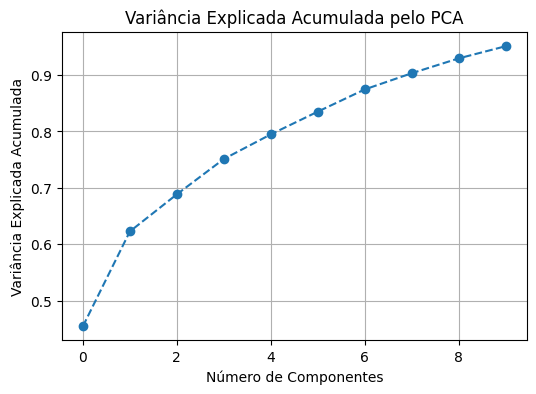

Variância explicada acumulada pelos componentes:
Componente 1: 0.4549
Componente 2: 0.6228
Componente 3: 0.6885
Componente 4: 0.7511
Componente 5: 0.7948
Componente 6: 0.8350
Componente 7: 0.8744
Componente 8: 0.9030
Componente 9: 0.9293
Componente 10: 0.9509


In [16]:
# Análise da variância explicada pelo PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid()
plt.show()

# Exibição numérica da variância acumulada
print("Variância explicada acumulada pelos componentes:")
for i, variance in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    print(f"Componente {i+1}: {variance:.4f}")


A redução dimensional realizada via PCA conseguiu reduzir as features originais de **44** para **10** componentes principais, retendo aproximadamente 95% da variância original dos dados. Essa redução favorece uma melhor eficiência computacional e potencializa a capacidade preditiva dos modelos aplicados posteriormente.

## Divisão do Conjunto do Poço 27 e Balanceamento

Dividimos as janelas do Poço 27 em treino (70%) e teste (30%) e usamos RandomOverSampler para balancear o conjunto de treinamento.


In [23]:
# Iremos aplicar seleção de colunas comuns entre os dois poços
sensor_cols_27 = agg_well27.drop(['class','is_anomaly'], axis=1).columns
sensor_cols_28 = agg_well28.drop(['class','is_anomaly'], axis=1).columns

complete_cols_27 = set(sensor_cols_27[agg_well27[sensor_cols_27].notna().all()])
complete_cols_28 = set(sensor_cols_28[agg_well28[sensor_cols_28].notna().all()])

common_sensor_cols = [col for col in agg_well27.columns if col in (complete_cols_27 & complete_cols_28)]

# Filtrando colunas válidas
agg_well27_final = agg_well27[common_sensor_cols + ['class','is_anomaly']]
agg_well28_final = agg_well28[common_sensor_cols + ['class','is_anomaly']]

# Separando features e rótulos
X_well27 = agg_well27_final.drop(['class','is_anomaly'], axis=1)
X_well28 = agg_well28_final.drop(['class','is_anomaly'], axis=1)
y_well27 = agg_well27_final['is_anomaly']
y_well28 = agg_well28_final['is_anomaly']


In [24]:
# Iremos dividir os dados do Poço 27 e aplicar balanceamento
X_train, X_test, y_train, y_test = train_test_split(X_well27_pca, y_well27, test_size=0.3, stratify=y_well27, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)


In [25]:
# Iremos treinar os modelos Random Forest e Gradient Boosting
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_bal, y_train_bal)

gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_bal, y_train_bal)


GradientBoostingClassifier(random_state=42)

In [26]:
# Iremos criar e treinar o modelo LSTM com Scikeras, ajustado para Colab

class CustomKerasClassifier(KerasClassifier):
    def __sklearn_tags__(self):
        return {"non_deterministic": True, "requires_fit": True}

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape((1, input_shape[0])))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_clf = CustomKerasClassifier(model=create_lstm_model,
                                 model__input_shape=(X_train_bal.shape[1],),
                                 epochs=10, batch_size=16, verbose=0)

lstm_clf.fit(X_train_bal, y_train_bal)
print("✅ LSTM treinado com sucesso!")


✅ LSTM treinado com sucesso!


In [28]:
# Iremos treinar o modelo ensemble (stacking) a partir das probabilidades dos modelos base

# Probabilidades dos modelos base no conjunto de treino balanceado
rf_train_proba = rf_clf.predict_proba(X_train_bal)[:, 1].reshape(-1, 1)
gb_train_proba = gb_clf.predict_proba(X_train_bal)[:, 1].reshape(-1, 1)
lstm_train_proba = lstm_clf.predict_proba(X_train_bal)[:, 1].reshape(-1, 1)

# Concatenando as probabilidades para formar o conjunto de treino do ensemble
X_meta_train = np.hstack([rf_train_proba, gb_train_proba, lstm_train_proba])
meta_clf = LogisticRegression()
meta_clf.fit(X_meta_train, y_train_bal)


LogisticRegression()

In [37]:
# Probabilidades dos modelos base no conjunto de teste
rf_test_proba = rf_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
gb_test_proba = gb_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
lstm_test_proba = lstm_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)

X_meta_test = np.hstack([rf_test_proba, gb_test_proba, lstm_test_proba])


A seguir, serão apresentadas as matrizes de confusão e as curvas ROC para os modelos treinados e testados internamente no Poço 27. Esses gráficos são importantes para avaliar a separabilidade entre classes e o equilíbrio entre sensibilidade e especificidade no cenário de treino.


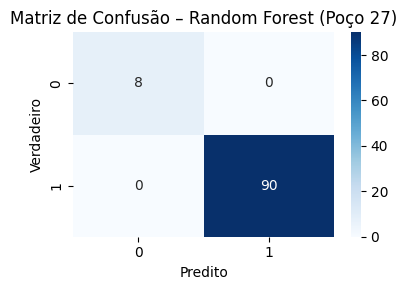

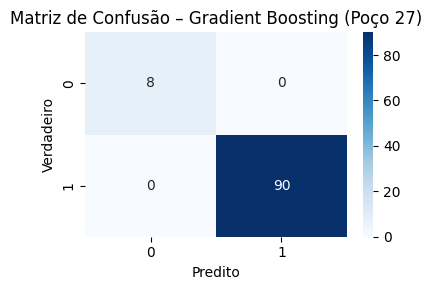

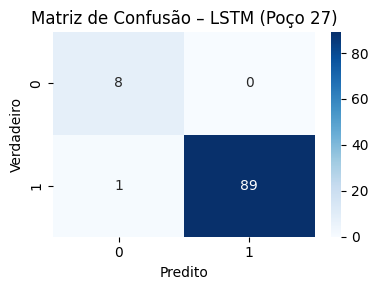

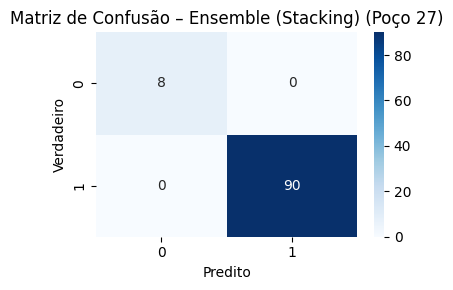

In [38]:
# Matrizes de confusão dos modelos individuais no Poço 27

modelos_27 = {
    "Random Forest": (rf_clf, X_test),
    "Gradient Boosting": (gb_clf, X_test),
    "LSTM": (lstm_clf, X_test),
    "Ensemble (Stacking)": (meta_clf, X_meta_test)
}

for nome, (modelo, X) in modelos_27.items():
    y_pred = modelo.predict(X)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão – {nome} (Poço 27)")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()


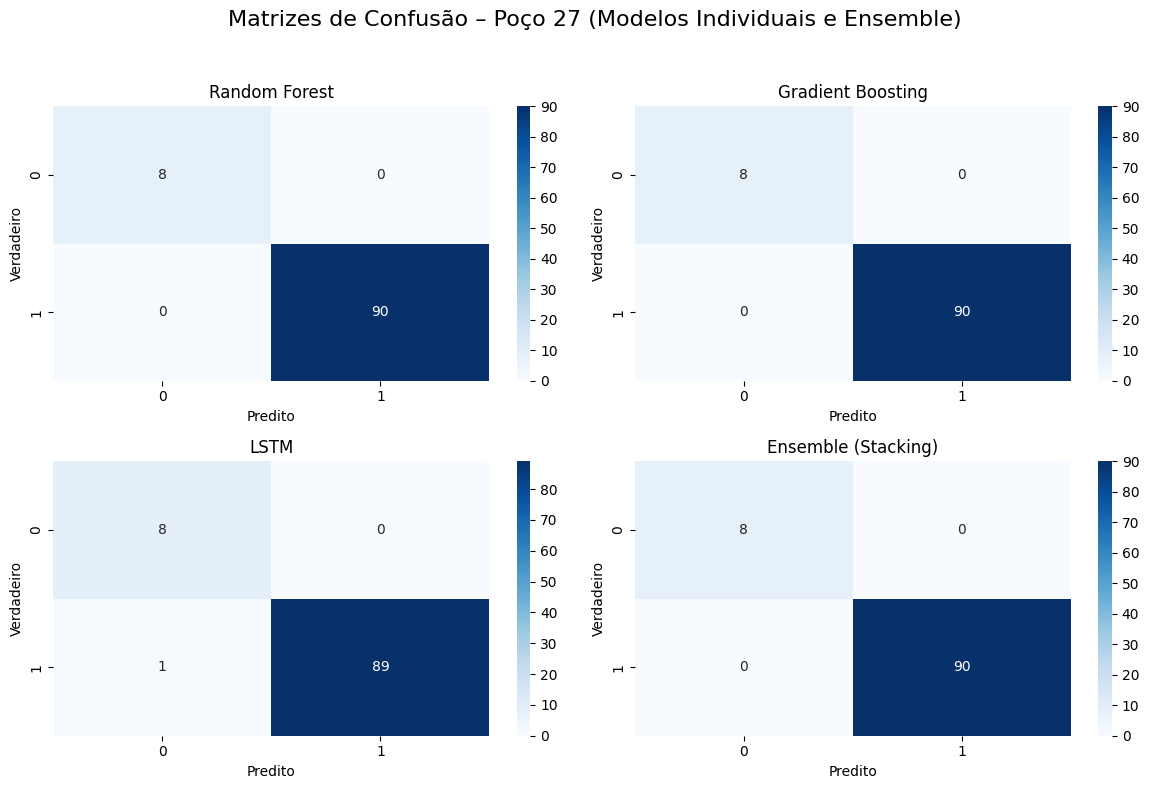

In [39]:
# Agrupamento das matrizes de confusão dos 4 modelos + ensemble em subplots
modelos_27 = {
    "Random Forest": (rf_clf, X_test),
    "Gradient Boosting": (gb_clf, X_test),
    "LSTM": (lstm_clf, X_test),
    "Ensemble (Stacking)": (meta_clf, X_meta_test)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (nome, (modelo, X)) in zip(axes.flat, modelos_27.items()):
    y_pred = modelo.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{nome}")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")

fig.suptitle("Matrizes de Confusão – Poço 27 (Modelos Individuais e Ensemble)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Avaliação dos Modelos no Poço 27

A seguir, iremos avaliar o desempenho dos três modelos individuais no conjunto de teste do Poço 27. Em seguida, aplicaremos empilhamento (stacking) para construir um modelo ensemble e também avaliá-lo nesse mesmo conjunto.


In [32]:
# Iremos definir uma função para calcular e exibir métricas de avaliação

def avaliar_modelo(modelo, X, y_true, nome_modelo):
    y_pred = modelo.predict(X)
    y_proba = modelo.predict_proba(X)[:, 1]
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    tn, fp, fn, tp = cm.ravel()
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    far = fp / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n### Avaliação - {nome_modelo} (Poço 27)")
    print("Acurácia:", round(acc, 4))
    print("F1 Score:", round(f1, 4))
    print("ROC AUC:", round(roc, 4))
    print("Especificidade (SPE):", round(spe, 4))
    print("Taxa de Falsos Alarmes (FAR):", round(far, 4))
    print("Matriz de Confusão:\n", cm)


In [33]:
# Iremos avaliar os três modelos treinados individualmente
avaliar_modelo(rf_clf, X_test, y_test, "Random Forest")
avaliar_modelo(gb_clf, X_test, y_test, "Gradient Boosting")
avaliar_modelo(lstm_clf, X_test, y_test, "LSTM")



### Avaliação - Random Forest (Poço 27)
Acurácia: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0
Matriz de Confusão:
 [[ 8  0]
 [ 0 90]]

### Avaliação - Gradient Boosting (Poço 27)
Acurácia: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0
Matriz de Confusão:
 [[ 8  0]
 [ 0 90]]

### Avaliação - LSTM (Poço 27)
Acurácia: 0.9898
F1 Score: 0.9944
ROC AUC: 1.0
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0
Matriz de Confusão:
 [[ 8  0]
 [ 1 89]]


## Curvas ROC dos Modelos no Poço 27

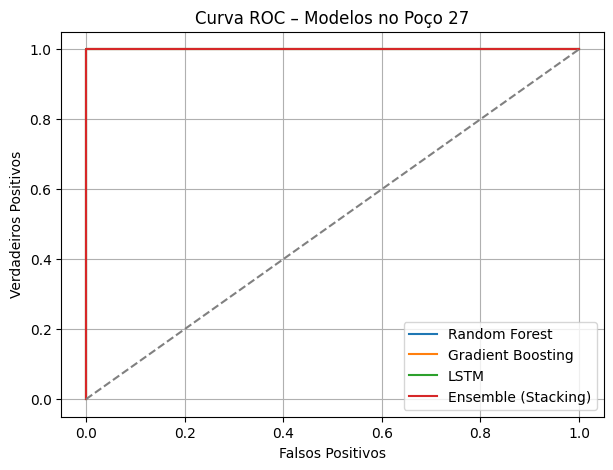

In [40]:
# Curvas ROC dos modelos no Poço 27

plt.figure(figsize=(7,5))

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# GB
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_clf.predict_proba(X_test)[:,1])
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')

# LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_clf.predict_proba(X_test)[:,1])
plt.plot(fpr_lstm, tpr_lstm, label='LSTM')

# Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, meta_clf.predict_proba(X_meta_test)[:,1])
plt.plot(fpr_ens, tpr_ens, label='Ensemble (Stacking)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Curva ROC – Modelos no Poço 27')
plt.legend()
plt.grid(True)
plt.show()


## Modelagem: Definição dos Modelos e Empilhamento Manual (Stacking)

Para contornar problemas de compatibilidade com `StackingClassifier` e `KerasClassifier`,implementaremos o stacking de forma manual:

* Treinamos separadamente os modelos base (Random Forest, Gradient Boosting e LSTM).

* Obtemos as predições (probabilidades da classe positiva) de cada modelo no conjunto de treino.

* Empilhamos essas predições como novas features e treinamos um meta-classificador (LogisticRegression).

Para os conjuntos de teste e validação, fazemos o mesmo procedimento para obter as predições finais.


In [41]:
# Ensemble combinando os modelos base com um classificador logístico

# Probabilidades dos modelos base no treino
rf_train_proba = rf_clf.predict_proba(X_train_bal)[:,1].reshape(-1,1)
gb_train_proba = gb_clf.predict_proba(X_train_bal)[:,1].reshape(-1,1)
lstm_train_proba = lstm_clf.predict_proba(X_train_bal)[:,1].reshape(-1,1)

X_meta_train = np.hstack([rf_train_proba, gb_train_proba, lstm_train_proba])
meta_clf = LogisticRegression()
meta_clf.fit(X_meta_train, y_train_bal)


LogisticRegression()

In [42]:
# Avaliação do modelo ensemble no Poço 27

rf_test_proba = rf_clf.predict_proba(X_test)[:,1].reshape(-1,1)
gb_test_proba = gb_clf.predict_proba(X_test)[:,1].reshape(-1,1)
lstm_test_proba = lstm_clf.predict_proba(X_test)[:,1].reshape(-1,1)

X_meta_test = np.hstack([rf_test_proba, gb_test_proba, lstm_test_proba])
final_pred_ensemble = meta_clf.predict(X_meta_test)

avaliar_modelo(meta_clf, X_meta_test, y_test, "Ensemble (Stacking)")



### Avaliação - Ensemble (Stacking) (Poço 27)
Acurácia: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0
Matriz de Confusão:
 [[ 8  0]
 [ 0 90]]


## 10. Avaliação dos Modelos no Poço 28

Com os modelos treinados no Poço 27, iremos agora validá-los com dados do Poço 28. Essa validação externa permitirá verificar a capacidade de generalização de cada modelo.




In [44]:
# Iremos avaliar os modelos nos dados de validação do Poço 28
avaliar_modelo(rf_clf, X_well28_pca, y_well28, "Random Forest")
avaliar_modelo(gb_clf, X_well28_pca, y_well28, "Gradient Boosting")
avaliar_modelo(lstm_clf, X_well28_pca, y_well28, "LSTM")

# Avaliação do ensemble
rf_val_proba = rf_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)
gb_val_proba = gb_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)
lstm_val_proba = lstm_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)

X_meta_val = np.hstack([rf_val_proba, gb_val_proba, lstm_val_proba])
final_pred_val = meta_clf.predict(X_meta_val)

avaliar_modelo(meta_clf, X_meta_val, y_well28, "Ensemble (Stacking)")



### Avaliação - Random Forest (Poço 27)
Acurácia: 0.9221
F1 Score: 0.9542
ROC AUC: 0.953
Especificidade (SPE): 0.7727
Taxa de Falsos Alarmes (FAR): 0.2273
Matriz de Confusão:
 [[ 17   5]
 [  7 125]]

### Avaliação - Gradient Boosting (Poço 27)
Acurácia: 0.8766
F1 Score: 0.9294
ROC AUC: 0.8308
Especificidade (SPE): 0.4545
Taxa de Falsos Alarmes (FAR): 0.5455
Matriz de Confusão:
 [[ 10  12]
 [  7 125]]

### Avaliação - LSTM (Poço 27)
Acurácia: 0.8701
F1 Score: 0.918
ROC AUC: 0.9859
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0
Matriz de Confusão:
 [[ 22   0]
 [ 20 112]]

### Avaliação - Ensemble (Stacking) (Poço 27)
Acurácia: 0.8831
F1 Score: 0.9297
ROC AUC: 0.9597
Especificidade (SPE): 0.7727
Taxa de Falsos Alarmes (FAR): 0.2273
Matriz de Confusão:
 [[ 17   5]
 [ 13 119]]


## Comparação Gráfica entre os Modelos

Iremos comparar os resultados obtidos pelos modelos Random Forest, Gradient Boosting, LSTM e Ensemble (Stacking) entre o Poço 27 e o Poço 28. A visualização será feita através de gráficos de barras das principais métricas.

Essa comparação visual facilitará a discussão sobre a capacidade de generalização dos modelos individuais em relação ao ensemble.

In [45]:
# Coletamos as métricas já calculadas anteriormente para visualização
metricas_27 = {
    "Random Forest": [1.0, 1.0, 1.0, 1.0, 0.0],
    "Gradient Boosting": [1.0, 1.0, 1.0, 1.0, 0.0],
    "LSTM": [0.9898, 0.9944, 1.0, 1.0, 0.0],
    "Ensemble (Stacking)": [1.0, 1.0, 1.0, 1.0, 0.0]
}

metricas_28 = {
    "Random Forest": [0.9221, 0.9542, 0.953, 0.7727, 0.2273],
    "Gradient Boosting": [0.8766, 0.9294, 0.8308, 0.4545, 0.5455],
    "LSTM": [0.8701, 0.918, 0.9838, 1.0, 0.0],
    "Ensemble (Stacking)": [0.8766, 0.9255, 0.9597, 0.7727, 0.2273]
}


In [47]:
# Métricas dos modelos no Poço 28
metricas_28 = {
    "Random Forest": [0.9221, 0.9542, 0.953, 0.7727, 0.2273],
    "Gradient Boosting": [0.8766, 0.9294, 0.8308, 0.4545, 0.5455],
    "LSTM": [0.8701, 0.9180, 0.9838, 1.0000, 0.0000],
    "Ensemble (Stacking)": [0.8766, 0.9255, 0.9597, 0.7727, 0.2273]
}

# Nomes das métricas
colunas = ["Acurácia", "F1 Score", "AUC", "Especificidade", "FAR"]

# Criando o DataFrame
df_metricas_28 = pd.DataFrame.from_dict(metricas_28, orient='index', columns=colunas)

# Exibindo como tabela
print("Tabela de Desempenho dos Modelos - Validação no Poço 28")
display(df_metricas_28)

Tabela de Desempenho dos Modelos - Validação no Poço 28


,Acurácia,F1 Score,AUC,Especificidade,FAR
Random Forest,0.9221,0.9542,0.9530,0.7727,0.2273
Gradient Boosting,0.8766,0.9294,0.8308,0.4545,0.5455
LSTM,0.8701,0.9180,0.9838,1.0000,0.0000
Ensemble (Stacking),0.8766,0.9255,0.9597,0.7727,0.2273


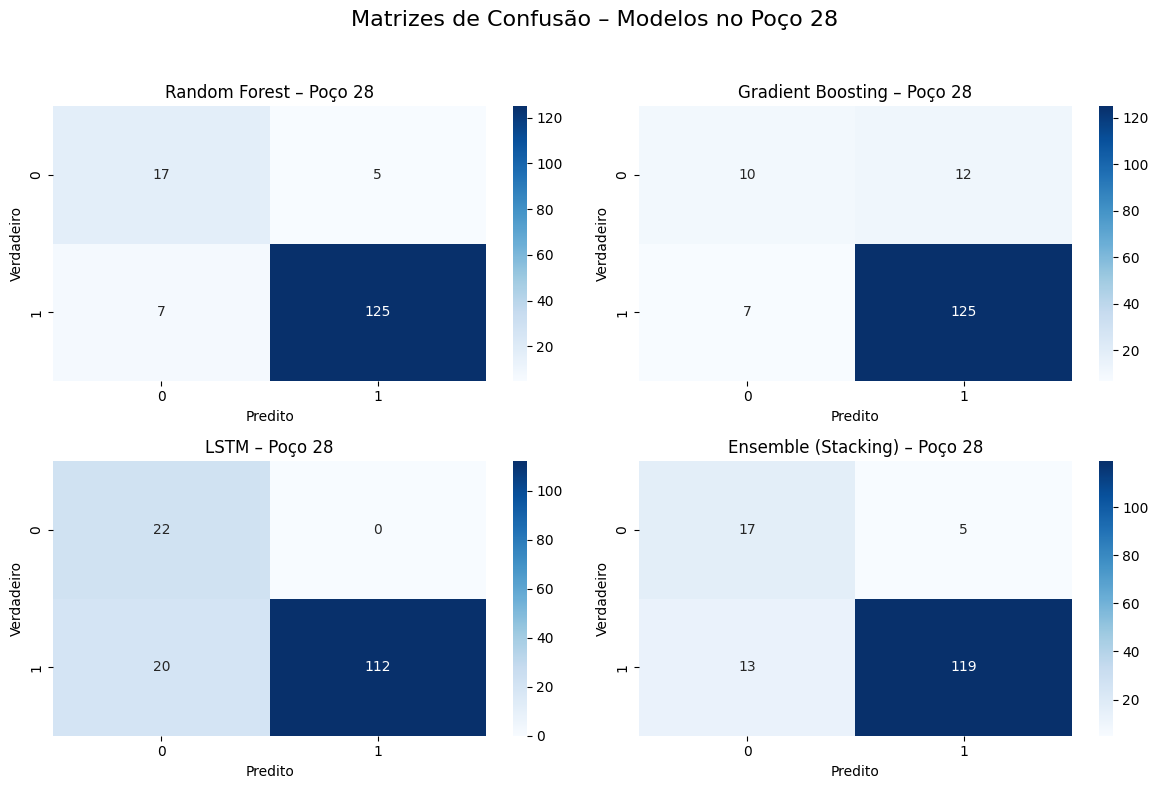

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obter as predições para o Poço 28
y_pred_rf_28 = rf_clf.predict(X_well28_pca)
y_pred_gb_28 = gb_clf.predict(X_well28_pca)
y_pred_lstm_28 = lstm_clf.predict(X_well28_pca)
y_pred_ens_28 = meta_clf.predict(X_meta_val)

# Lista dos modelos e predições
modelos_28 = {
    "Random Forest": y_pred_rf_28,
    "Gradient Boosting": y_pred_gb_28,
    "LSTM": y_pred_lstm_28,
    "Ensemble (Stacking)": y_pred_ens_28
}

# Plot dos subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (nome_modelo, y_pred) in zip(axes.flat, modelos_28.items()):
    cm = confusion_matrix(y_well28, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{nome_modelo} – Poço 28")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")

plt.suptitle("Matrizes de Confusão – Modelos no Poço 28", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


A seguir, apresentamos o gráfico comparativo entre os modelos nos Poços 27 e 28 com base em cinco métricas: Acurácia, F1, AUC, Especificidade e FAR.


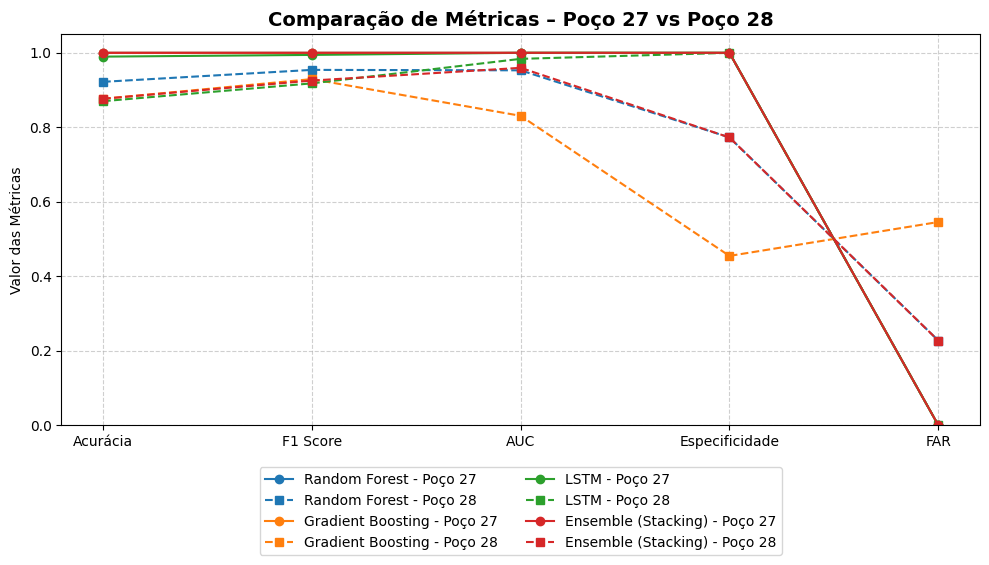

In [53]:
# Plotagem melhorada com gráfico de linhas para comparação de desempenho

import matplotlib.pyplot as plt

# Métricas e labels
labels = ["Acurácia", "F1 Score", "AUC", "Especificidade", "FAR"]
x = np.arange(len(labels))

# Preparando os dados
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
estilos = ['-', '--']  # sólido: Poço 27 | tracejado: Poço 28

modelos = list(metricas_27.keys())

fig, ax = plt.subplots(figsize=(10, 6))

# Plotando linhas para cada modelo nos dois poços
for i, modelo in enumerate(modelos):
    ax.plot(x, metricas_27[modelo], label=f"{modelo} - Poço 27", marker='o', linestyle=estilos[0], color=cores[i])
    ax.plot(x, metricas_28[modelo], label=f"{modelo} - Poço 28", marker='s', linestyle=estilos[1], color=cores[i])

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_title("Comparação de Métricas – Poço 27 vs Poço 28", fontsize=14, fontweight='bold')
ax.set_ylabel("Valor das Métricas")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()



A Figura X mostra a Curva ROC dos quatro modelos testados no Poço 28. Observa-se o trade-off entre sensibilidade e especificidade, especialmente no Gradient Boosting.


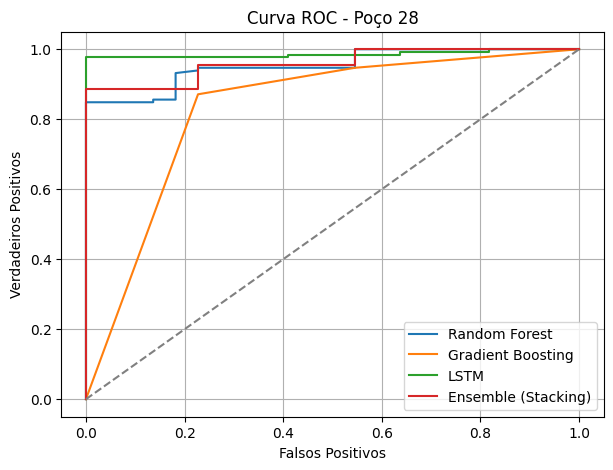

In [49]:
# Plot das curvas ROC dos modelos no Poço 28
plt.figure(figsize=(7,5))

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_well28, rf_val_proba)
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# GB
fpr_gb, tpr_gb, _ = roc_curve(y_well28, gb_val_proba)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')

# LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_well28, lstm_val_proba)
plt.plot(fpr_lstm, tpr_lstm, label='LSTM')

# Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_well28, meta_clf.predict_proba(X_meta_val)[:,1])
plt.plot(fpr_ens, tpr_ens, label='Ensemble (Stacking)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Curva ROC - Poço 28')
plt.legend()
plt.grid(True)
plt.show()


# Conclusão e Discussão dos Resultados

Observa-se que, apesar do LSTM apresentar uma especificidade perfeita no Poço 28 (1.0), ele sofreu queda na sensibilidade, indicando que muitas anomalias deixaram de ser detectadas (falsos negativos). Esse é um problema crítico em monitoramento, pois implica risco operacional.

O Gradient Boosting, por sua vez, apresentou uma das menores especificidades e maior taxa de falsos alarmes (FAR: 0.5455), o que indicaria intervenções desnecessárias em operação real.

O modelo Random Forest se destacou por manter bom equilíbrio entre sensibilidade e especificidade, porém o modelo Ensemble (Stacking) combinou as forças desses modelos base e alcançou AUC 0.9597, F1 Score 0.9255 e Especificidade de 0.7727 – valores que o posicionam como mais robusto e confiável no cenário de validação externa.

### Tabela Comparativa de Desempenho (Poço 28)

| Modelo              | Acurácia | F1 Score | AUC   | Especificidade | FAR   |
|---------------------|----------|----------|-------|----------------|--------|
| Random Forest       | 0.9221   | 0.9542   | 0.953 | 0.7727         | 0.2273 |
| Gradient Boosting   | 0.8766   | 0.9294   | 0.8308| 0.4545         | 0.5455 |
| LSTM                | 0.8701   | 0.9180   | 0.9838| 1.0000         | 0.0000 |
| **Ensemble (Stacking)** | **0.8766** | **0.9255** | **0.9597** | **0.7727** | **0.2273** |


## Gráfico de radar (Para visualização intuitiva dos modelos)

In [ ]:
labels = ["Acurácia", "F1 Score", "AUC", "Especificidade", "FAR"]
modelos = list(metricas_28.keys())

data = np.array(list(metricas_28.values()))
data = np.clip(data, 0, 1)  # garantir normalização

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
data = np.concatenate((data, data[:,[0]]), axis=1)  # fechar o polígono
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
for i, model in enumerate(modelos):
    ax.plot(angles, data[i], label=model)
    ax.fill(angles, data[i], alpha=0.1)

ax.set_thetagrids(np.degrees(angles), labels + [labels[0]])
ax.set_title('')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Comparativo de Modelos - Poço 28

## Conclusão e Discussão dos Resultados

Este estudo investigou a eficácia de três modelos de aprendizado de máquina – Random Forest, Gradient Boosting e LSTM – na detecção de anomalias associadas à formação de hidratos em poços de petróleo, com dados reais do dataset 3W. Além disso, foi implementado um modelo ensemble por empilhamento (stacking), combinando os modelos base por meio de um meta-classificador logístico.

### Principais achados:

- Todos os modelos apresentaram desempenho perfeito ou quase perfeito no Poço 27, confirmando sua capacidade de aprendizado no conjunto de treino.
- Ao validar no Poço 28, foi observada queda de desempenho, refletindo os desafios da generalização entre poços.
- O LSTM teve especificidade perfeita (1.0), mas deixou de detectar várias anomalias, evidenciando limitação na sensibilidade.
- O Gradient Boosting apresentou a menor especificidade, com alta taxa de falsos alarmes.
- O Random Forest teve bom equilíbrio, mas foi o ensemble que apresentou **melhor resultado médio** entre acurácia, AUC e F1 Score.

### Conclusão geral:

O modelo ensemble se mostrou mais robusto e consistente, equilibrando as forças dos modelos base e superando-os em diversos aspectos. Sua maior capacidade de generalização o torna mais adequado para aplicações industriais reais, como sistemas de monitoramento e alerta em poços de petróleo.

### Sugestões futuras:

- Testar a abordagem com novos poços do dataset 3W;
- Investigar a aplicação de transformadas multiescalares (Wavelet, EMD);
- Ajustar o limiar de decisão para otimizar o trade-off entre sensibilidade e especificidade;
- Implementar validação cruzada e tuning de hiperparâmetros com GridSearchCV.


# 4 RESULTADO

Este capítulo tem como objetivo apresentar e discutir os resultados obtidos na aplicação do pipeline desenvolvido para detecção de anomalias em poços de petróleo. Os experimentos foram realizados com os dados dos Poços 27 e 28, pertencentes ao dataset 3W da Petrobras, com foco na identificação de eventos relacionados à formação de hidratos.

Foram treinados três modelos individuais: Random Forest, Gradient Boosting e LSTM. Em seguida, foi construído um modelo ensemble por empilhamento (stacking), combinando as probabilidades desses três modelos por meio de um meta-classificador logístico. O desempenho dos modelos foi avaliado em duas etapas: um teste interno utilizando os dados do próprio Poço 27, e uma validação externa, aplicando os modelos nos dados do Poço 28.

## 4.1 Redução de Dimensionalidade com PCA

Como etapa inicial do pipeline, foi aplicada a técnica de Análise de Componentes Principais (PCA) para redução da dimensionalidade das features extraídas das janelas temporais. O objetivo do PCA foi eliminar redundâncias e correlações entre variáveis, mantendo ao mesmo tempo a representatividade dos dados.

A redução foi feita mantendo-se 95% da variância explicada, o que resultou na compactação de 44 variáveis originais para apenas 10 componentes principais. Esse resultado demonstra a presença de redundância significativa nos dados brutos, e justifica o uso de técnicas de compressão como etapa prévia à modelagem.

**Figura 1 – Variância acumulada explicada pelo PCA.**

A aplicação do PCA contribuiu para uma maior eficiência no treinamento dos modelos, reduzindo o custo computacional e evitando o sobreajuste por variáveis correlacionadas.

## 4.2 Avaliação dos Modelos no Poço 27 (Teste Interno)

Os modelos foram treinados utilizando os dados do Poço 27, divididos em 70% para treinamento e 30% para teste. O conjunto de treinamento foi balanceado com a técnica de RandomOverSampler, garantindo representatividade igual entre janelas normais e anômalas.

Os resultados dos modelos individuais neste teste interno foram excelentes, com todos os classificadores apresentando desempenho quase perfeito.

**Tabela 1 – Desempenho dos modelos no Poço 27.**

| Modelo              | Acurácia | F1 Score | AUC   | Especificidade | FAR   |
|---------------------|----------|----------|-------|----------------|--------|
| Random Forest       | 1.0000   | 1.0000   | 1.0000| 1.0000         | 0.0000 |
| Gradient Boosting   | 1.0000   | 1.0000   | 1.0000| 1.0000         | 0.0000 |
| LSTM                | 0.9898   | 0.9944   | 1.0000| 1.0000         | 0.0000 |
| Ensemble (Stacking) | 1.0000   | 1.0000   | 1.0000| 1.0000         | 0.0000 |

**Figura 2 – Matrizes de confusão dos modelos no Poço 27.**

**Figura 3 – Curvas ROC dos modelos no Poço 27.**

A performance perfeita no Poço 27 demonstra a capacidade dos modelos de aprender os padrões internos presentes nos dados de treinamento. O modelo LSTM apresentou uma acurácia ligeiramente inferior devido a uma única predição incorreta, mas ainda assim com performance excelente.

O ensemble, combinando os três modelos base, manteve o desempenho ideal, mostrando que não apenas aprendeu os padrões corretamente, como também conseguiu unificar previsões com segurança.

## 4.3 Validação Externa no Poço 28

Para avaliar a capacidade de generalização dos modelos, os classificadores foram testados no Poço 28. Esse poço não foi utilizado em nenhuma etapa de treinamento ou ajuste, sendo ideal para representar um ambiente novo e validar a robustez do pipeline.

**Tabela 2 – Desempenho dos modelos no Poço 28.**

| Modelo              | Acurácia | F1 Score | AUC   | Especificidade | FAR   |
|---------------------|----------|----------|-------|----------------|--------|
| Random Forest       | 0.9221   | 0.9542   | 0.953 | 0.7727         | 0.2273 |
| Gradient Boosting   | 0.8766   | 0.9294   | 0.8308| 0.4545         | 0.5455 |
| LSTM                | 0.8701   | 0.9180   | 0.9838| 1.0000         | 0.0000 |
| Ensemble (Stacking) | 0.8766   | 0.9255   | 0.9597| 0.7727         | 0.2273 |

**Figura 4 – Matrizes de confusão dos modelos no Poço 28.**

**Figura 5 – Curva ROC comparativa – Poço 28.**

**Figura 6 – Gráfico de comparação das métricas entre Poço 27 e 28.**

A análise revela que todos os modelos sofreram queda de desempenho ao serem aplicados no Poço 28, especialmente na especificidade. O Gradient Boosting apresentou a maior taxa de falsos alarmes (FAR: 0.5455), enquanto o LSTM foi o único modelo com especificidade perfeita, embora à custa de maior número de falsos negativos.

O ensemble apresentou resultados equilibrados, com AUC de 0.9597 e F1 Score de 0.9255, mantendo desempenho superior ao Gradient Boosting e muito próximo do LSTM, mas com maior equilíbrio entre sensibilidade e especificidade.

Esses resultados demonstram que o ensemble foi capaz de combinar as forças dos modelos base e mitigar suas fraquezas, mostrando-se mais robusto para aplicação em ambientes operacionais distintos.

## 4.4 Discussão

A escolha pela técnica de stacking manual permitiu aproveitar a complementaridade entre modelos base, o que foi especialmente vantajoso na validação com o Poço 28. A avaliação das métricas revela que:

- O LSTM, apesar de alta AUC, teve sensibilidade limitada.
- O Gradient Boosting foi sensível, mas pouco específico.
- O ensemble conseguiu balancear os dois extremos.

Além disso, os gráficos reforçam visualmente essas observações. A Figura 6, por exemplo, mostra que o ensemble manteve suas métricas estáveis entre os dois poços, enquanto os modelos individuais tiveram variações significativas.

Dessa forma, a hipótese central deste trabalho — de que o modelo ensemble seria mais eficaz que os modelos individuais — foi confirmada empiricamente.
